In [150]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

class Newtonian(pybamm.BaseModel):
    def __init__(self, param, name= "Newtonian model"):
        super().__init__(name=name) #This initiaties the inherited class
        self.param = param

        ##################
        #Define parameter
        ##################
        #for velocity_profile and thickness_convergence
        P = pybamm.Parameter("Pressure [Pa]")
        U = pybamm.Parameter("Coating speed [ms-1]")

        #for viscosity_profile
        mu = pybamm.Parameter("Newtionian viscosity [Pa]")

        #################
        #Define variables
        #################
        #for velocity_profile and thickness_convergence
        u = pybamm.Variable("Velocity  [ms-1]", domain = "coating")
        y = pybamm.SpatialVariable("y [m]", domain="coating", coord_sys="cartesian")

        #for viscosity_profile
        #gamma = pybamm.Variable("Shear strain [s-1]", domain="rheology")
        #tau = pybamm.Variable("Shear stress [Pa]")
        
        ####################
        #Governing equations
        ####################
        #for velocity_profile and thickness_convergence
        grad = pybamm.grad(u)
        self.algebraic[u] = pybamm.div(grad)-P

        #for viscosity_profile
        #self.algebraic[gamma] = mu*gamma - tau

        ####################
        #Boundary conditions
        ####################
        #for velocity_profile and thickness_convergence
        self.boundary_conditions = {u: {"left": (U, "Dirichlet"), "right": (0, "Dirichlet")}}
        self.initial_conditions = {u: U}

        #for viscosity_profile
        #self.boundary_conditions = {gamma: {"left": (5, "Dirichlet"), "right": (0, "Dirichlet")}}
        #self.initial_conditions = {gamma: 0}
        ##################
        #Output variables
        ##################
        self.variables.update({
            "Velocity  [ms-1]": u,
            "Coating thickness [m]": pybamm.Integral(u, y)/U,
            "y [m]": y,
        #    "Shear strain [s-1]": gamma,
        #    "Shear stress [Pa]": tau,
        })
    
    @property
    def default_geometry(self):
        H_g = pybamm.Parameter("Coating Gap [m]")
        y = self.variables["y [m]"]
        return {"coating": {y: {"min": pybamm.Scalar(0), "max": H_g}}}
    
    @property
    def default_var_pts(self):
        y = self.variables["y [m]"]
        return {y: 20}
    
    @property
    def default_submesh_types(self):
        return {"coating": pybamm.Uniform1DSubMesh}
    
    @property
    def default_spatial_methods(self):
        return {"coating": pybamm.FiniteVolume()}
    
    def velocity_profile(self, P_lower=-1, P_upper=4, normalised=0):
        sim = pybamm.Simulation(self, parameter_values=self.param)
        solutions = []
        
        U = self.param["Coating speed [ms-1]"]
        H_g = self.param["Coating Gap [m]"]

        for P in range(P_lower,P_upper):
            sol = sim.solve([0, 1], inputs={"Pressure [Pa]": P})
            solutions.append(sol)
            
        for sol in solutions:
            y = sol["y [m]"](t=0)
            u = sol["Velocity  [ms-1]"](t=0)
            if normalised == 0:
                plt.plot(u, y)
                plt.ylim([0, H_g])
                plt.ylabel(r"Height [$\mu m$]")
                plt.xlabel(r"Velocity [$m/min$]")
            elif normalised == 1:
                plt.plot(u/U, y/H_g)
                plt.ylim([0, 1])
                plt.ylabel(r"$y/h$")
                plt.xlabel(r"$u/v_0$")

        #Figure caption
        txt="Figure 1: Results of analytical modelling for a velocity profile below the slot die region with different pressure heads using the" + " {} ".format(self.name)
        plt.figtext(0.5, -0.15, txt, wrap=True, horizontalalignment='center', fontsize=12)
        plt.legend()
        plt.figure()

    def thickness_convergence(self):
        var_pts_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200]
        solutions = []
        thickness_list = []

        for pts in var_pts_list:
            sim = pybamm.Simulation(self, parameter_values=self.param, var_pts={self.variables["y [m]"]: pts})

            sol = sim.solve([0, 1], inputs={"Pressure [Pa]": 5})
            solutions.append(sol)

            thickness_list.append(sol["Coating thickness [m]"](t=0))   

        error_list = []

        for thickness in thickness_list:
            error = abs((thickness_list[-1] - thickness)/thickness_list[-1] *100) #need to add absolute value here
            print(error)
            error_list.append(error)  

        # plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4)) 

        ax1.plot(var_pts_list, thickness_list, "o-")
        ax1.axhline(y = thickness_list[-1], color = 'r', linestyle = '--') #thicknesses[-1] has been used as a temporary analytical solution    
        #ax1.ylim(thickness_list[0], thickness_list[-1]*1.1)
        ax1.set_xlabel("Mesh points")
        ax1.set_ylabel(r"Coating thickness [mm]")
        solutions = []

        ax2.axhline(y = 1, color = 'r', linestyle = '--')
        ax2.plot(var_pts_list, error_list)
        ax2.set_ylabel("Percentage error from analytical solution [%]")
        ax2.set_xlabel("Mesh points")
    
    def viscosity_profile(self):
        sim = pybamm.Simulation(self, parameter_values=self.param, solver=pybamm.DummySolver())
        sol = sim.solve([0, 1])
        print(sol)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


319.96640268810194
79.98560115204367
35.54471197869956
19.99040076802909
12.790976721947217
8.880178474693064
6.522090477739785
4.9916006720251955
3.942301899877125
3.191744660505063
0.7919366451433328
0.34752775341338793
0.1919846412941813
0.11999040083465061
0.02399808019136995
0.0


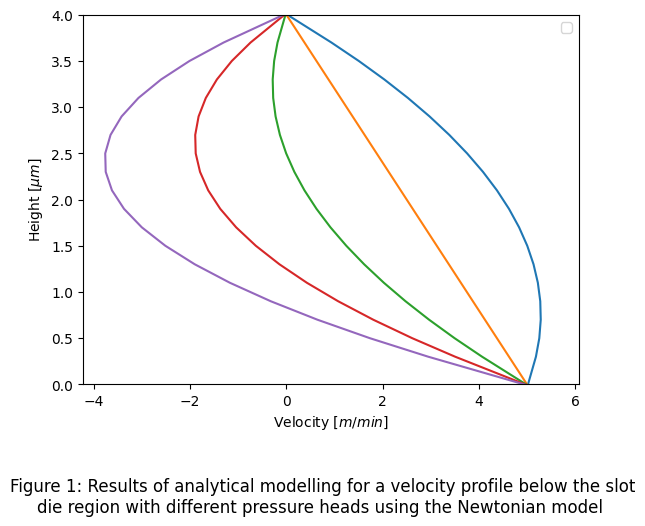

<Figure size 640x480 with 0 Axes>

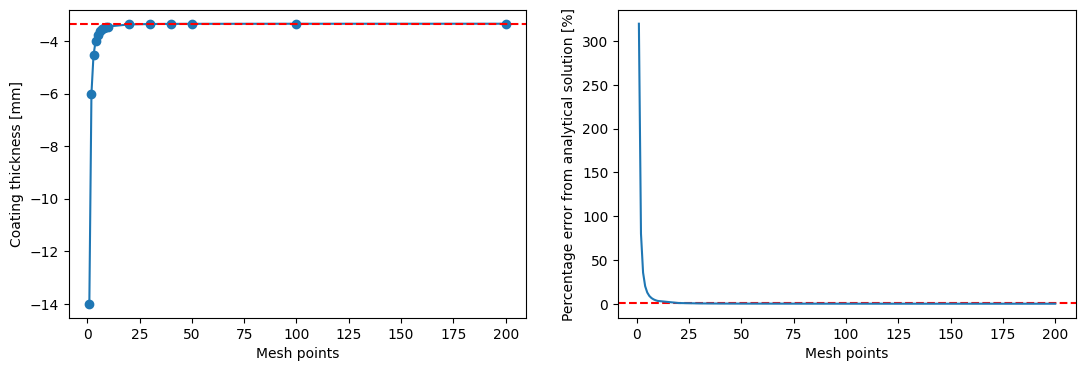

In [151]:
#Add parameters
param = pybamm.ParameterValues(
    {
        "Pressure [Pa]": "[input]",
        "Yield stress [Pa]": 2,
        "Exponent parameter [t]": 3,
        "Coating Gap [m]": 4,
        "Coating speed [ms-1]": 5,
        "Newtionian viscosity [Pa]": 3,
    }
)

model = Newtonian(param=param)
model.velocity_profile(normalised=0)
model.thickness_convergence()

#model.viscosity_profile()

(0.0, 1.0)

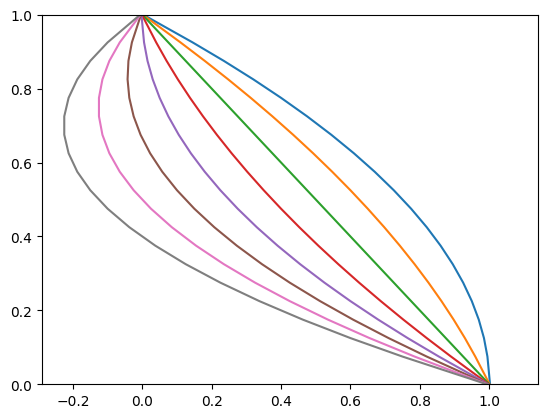

In [27]:
#Add parameters
param = pybamm.ParameterValues(
    {
        "Pressure [Pa]": "[input]",
        "Yield stress [Pa]": 2,
        "Exponent parameter [t]": 3,
        "Coating Gap [m]": 1,
        "Coating speed [ms-1]": 1,
    }
)

model = Newtonian(param=param)
sim = pybamm.Simulation(model, parameter_values=param)
solutions = []

for P in range(-2,6):
    sol = sim.solve([0, 1], inputs={"Pressure [Pa]": P})
    solutions.append(sol)
    
for sol in solutions:
    y = sol["y [m]"](t=0)
    u = sol["Velocity  [ms-1]"](t=0)
    plt.plot(u, y)
plt.ylim([0, 1])

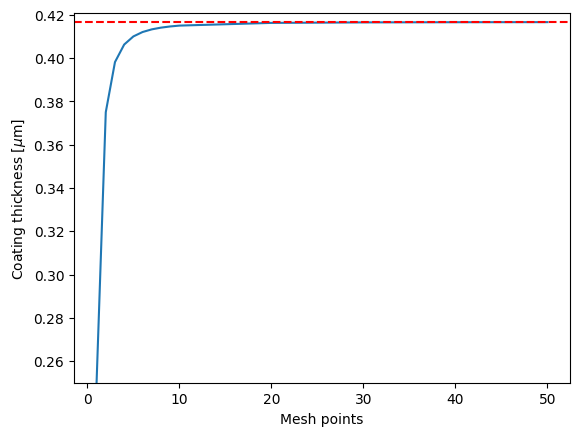

In [20]:
from sklearn.metrics import mean_squared_error
model = Newtonian()

#Add parameters
param = pybamm.ParameterValues(
    {
        "Pressure [Pa]": "[input]",
        "Yield stress [Pa]": 2,
        "Exponent parameter [t]": 3,
        "Coating Gap [m]": 1,
        "Coating speed [ms-1]": 5,
    }
)

var_pts_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
soulations = []
var_pts = {model.variables["y [m]"]: 20}
thickness_list = []

for pts in var_pts_list:
    sim = pybamm.Simulation(model, parameter_values=param, var_pts={model.variables["y [m]"]: pts})

    sol = sim.solve([0, 1], inputs={"Pressure [Pa]": 5})
    solutions.append(sol)

    thickness_list.append(sol["Coating thickness [m]"](t=0))

plt.plot(var_pts_list, thickness_list)
plt.axhline(y = thickness_list[-1], color = 'r', linestyle = '--') #thicknesses[-1] has been used as a temporary analytical solution    
plt.ylim(thickness_list[0], thickness_list[-1]*1.01)
plt.xlabel("Mesh points")
plt.ylabel(r"Coating thickness [$\mu$m]")
    
solutions = []

Text(0.5, 0, 'Mesh points')

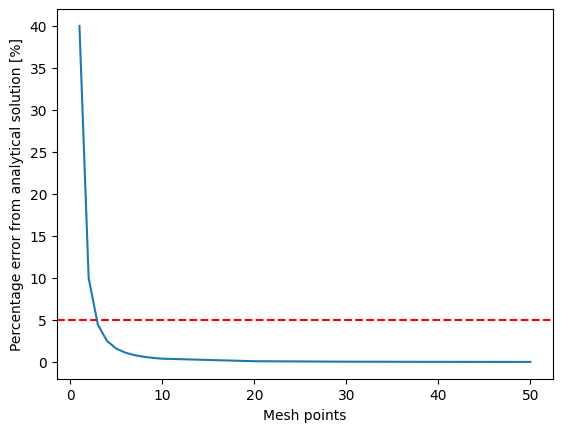

In [17]:
analytical_solution = (np.full((1, len(thickness_list)), thickness_list[-1]))[0]   

error_list = []

for thickness in thickness_list:
    error = (thickness_list[-1] - thickness)/thickness_list[-1] *100
    error_list.append(error)

plt.axhline(y = 5, color = 'r', linestyle = '--')
plt.plot(var_pts_list, error_list)
plt.ylabel("Percentage error from analytical solution [%]")
plt.xlabel("Mesh points")
